#  Analytics Experience - Group Project - MSCI:6040 

By Group 2 (Chris Wagner, Palden Williams, Tarun Mandava  - Data Scientists) 
- September, 2020                                                             

### Modeling SVC with Count Vectorizer text classification

This sample will use the Count Vectorizer for organizing the tweet text into common tokens.  This will then be applied to the SVC model we determined in the model evaluation phase.

#### Import Libraries

In [1]:
# Dependencies and the libraries to import

import pandas as pd
import matplotlib.pyplot as mplt
import seaborn as sn
import matplotlib.pyplot as plt                     
import numpy as np           
import plotly.offline as plyo
#import cufflinks as cf
#plyo.init_notebook_mode()


In [2]:
#  Further library imports

import random
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from collections import defaultdict
import string

from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from tqdm import tqdm
stop = stopwords.words('english')
sn.set_context('notebook')

#### Import the sample data sets

In [3]:
# Importing Kaggler data set

sub = pd.read_csv("Data/OriginalData/sample_submission.csv")
test_data = pd.read_csv("Data/OriginalData/test.csv")
train_data = pd.read_csv("Data/OriginalData/train.csv")


#### Remove any html characters

In [4]:
import re
def  remove_html(df, text):
    df[text] = df[text].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df

test_clean = remove_html(test_data, "text")
train_clean = remove_html(train_data, "text")


#### Remove any Emojii's from the text

In [5]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

test_clean['text']=test_clean['text'].apply(lambda x: remove_emoji(x))
train_clean['text']=train_clean['text'].apply(lambda x: remove_emoji(x))

##### Break up the text into common tokens based on the spacy library

This function will use the en_core_web_sm library to break up the tweet text into common components.  It will also remove any stopwords, punctuation, and exclude any pronouns.

The Lemma component will group words to their common root such as run, ran, running will all be associated with the word run.

In [6]:
nlp = spacy.load('en_core_web_md')
# Clean text before feeding it to model
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, puncuation and reducing all characters to lowercase 
def cleanup_text(docs, logging=False):
    texts = []
    for doc in tqdm(docs):
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        #remove stopwords and punctuations 
        tokens = [tok for tok in tokens if tok not in stop and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

##### The cleanup text function will be used to create a list of valid tokens per tweet.

In [7]:
train_clean['token'] = cleanup_text(train_clean['text'],logging=False)
test_clean['token'] = cleanup_text(test_clean['text'],logging=False)

100%|█████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:07<00:00, 438.75it/s]


In [8]:
train_clean.head()

,id,keyword,location,text,target,token
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to shelter in place are be...,1,resident ask shelter place notify officer evac...
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,get send photo ruby alaska smoke wildfire pour...


### Vectorization

The count vectorizer will be used to create a corpus of all of the words in the training set.  This will then be used to apply the words in any test set against the original train set.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
cv = CountVectorizer()

In [11]:
# Create a vector for both the train and test sets

train_vectors = cv.fit_transform(train_clean["token"])
test_vectors = cv.transform(test_clean["token"])

In [12]:
print(train_vectors[0].todense().shape)
print(train_vectors[0].todense())

(1, 14025)
[[0 0 0 ... 0 0 0]]


### Modeling

#### Applying the vectors to a SVC model for prediction.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from sklearn.model_selection import cross_val_score

In [14]:
#build the SVC model
sv= svm.SVC()

In [15]:
#score the svc model against the vectors generated by the count vectorizer
scores = cross_val_score(sv, train_vectors, train_clean["target"], cv=5)
scores

array([0.72619829, 0.65659882, 0.67235719, 0.6977661 , 0.77595269])

The scores look acceptable.  We'll now train the model based on the train vectors

In [16]:
sv.fit(train_vectors, train_clean["target"])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Now predict the test set for returning to Kaggle

In [17]:
sub.target = sv.predict(test_vectors)
sub.to_csv("countVect_submission.csv",index=False)

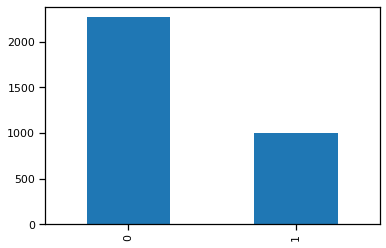

In [18]:
sub.target.value_counts().plot.bar();